In [ ]:
# all imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import norm


Matplotlib is building the font cache; this may take a moment.


In [41]:
# part 2 
# i. matching volatility 
# ii. mismatched volatility 

def bs_call_price(S, K, r, sigma, tau):
    """
    Calculate and return the Black-Scholes price of a European call option. 
    """
    d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * tau) / (sigma * np.sqrt(tau))
    d2 = (np.log(S / K) + (r - 0.5 * sigma**2) * tau) / (sigma * np.sqrt(tau))
    return S * norm.cdf(d1) - K * np.exp(-r * tau) * norm.cdf(d2)

def bs_delta_call(S, K, r, sigma, tau):
    """
    Calculate and return the Black-Scholes delta of a European call option.
    """
    d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * tau) / (sigma * np.sqrt(tau))
    return norm.cdf(d1)


def simulate_gbm_path(S0, r, sigma_real, T, n_steps, rng):
    """
    Simulate and return stock price path following a Geometric Brownian Motion
    """
    dt = T / n_steps
    t = np.linspace(0.0, T, n_steps + 1)
    dW = np.sqrt(dt) * rng.standard_normal(n_steps)

    # Brownian motion path 
    W = np.zeros(n_steps + 1)
    W[1:] = np.cumsum(dW)

    # Drift term
    drift = (r - 0.5 * sigma_real**2) * t

    # Explicit GBM solution
    S = S0 * np.exp(drift + sigma_real * W)

    return S
    
def hedge_short_call_one_path(S_path, K, r, sigma_delta, T, hedge_every_steps):
    """
    Perform discrete-time delta hedging of a short European call option along a simulated stock price path. 
    Return final hedging Profit & Loss.   
    """
    n_steps = len(S_path) - 1
    dt = T / n_steps

    # t=0: sell call & buy delta shares
    C0 = bs_call_price(S_path[0], K, r, sigma_delta, T)
    delta = bs_delta_call(S_path[0], K, r, sigma_delta, T)
    shares = delta
    cash = C0 - shares * S_path[0]

    for i in range(n_steps):
        cash *= np.exp(r * dt)
        S_next = S_path[i+1]
        tau_next = max(T - (i+1) * dt, 0.0)

        if (i + 1) % hedge_every_steps == 0 and tau_next > 0:
            new_delta = bs_delta_call(S_next, K, r, sigma_delta, tau_next)
            cash -= (new_delta - shares) * S_next
            shares = new_delta

    S_T = S_path[-1]
    payoff = max(S_T - K, 0.0)
    portfolio_T = shares * S_T + cash
    return portfolio_T - payoff


def run_hedge_experiment(
    sigma_real,
    sigma_delta,
    hedge_freqs=(1, 2, 5),
    S0=100.0,
    K=99.0,
    r=0.06,
    T=1.0,
    n_steps=252,
    n_paths=5000,
    seed=42,):
    """
    Run a Monte Carlot delta-hedging experiment in order to solve task 1 & task 2.
    Returns summary statistics in a DataFrame. 
    """
    rng = np.random.default_rng(seed)
    all_results = {}

    for freq in hedge_freqs:
        pnls = np.empty(n_paths)
        for p in range(n_paths):
            S_path = simulate_gbm_path(S0, r, sigma_real, T, n_steps, rng)
            pnls[p] = hedge_short_call_one_path(S_path, K, r, sigma_delta, T, freq)
        all_results[freq] = pnls

    # summary statistics 
    rows = []
    for freq in hedge_freqs:
        pnls = all_results[freq]
        rows.append({
            "sigma_real": sigma_real,
            "sigma_delta": sigma_delta,
            "hedge_every_days": freq,
            "mean_pnl": pnls.mean(),
            "std_pnl": pnls.std(ddof=1),
        })
    summary_df = pd.DataFrame(rows).sort_values(["hedge_every_days"])
    return all_results, summary_df

# Task 1
task1_results, task1_summary = run_hedge_experiment(
    sigma_real=0.20,
    sigma_delta=0.20,
    hedge_freqs=(1, 2, 5),
    n_paths=3000,   
    seed=1,
)
print("\ntask 1 summary:")
print(task1_summary.to_string(index=False))

# Task 2
sigma_delta_grid = [0.10, 0.15, 0.25, 0.30] 
sigma_real_fixed = 0.20

# hedge daily, twice a week, weekly 
hedge_freqs = (1, 2, 5)

task2_summaries = []
for sigma_delta in sigma_delta_grid:
    results, summary = run_hedge_experiment(
        sigma_real=sigma_real_fixed,
        sigma_delta=sigma_delta,
        hedge_freqs=(1,2,5),
        n_paths=3000,
        seed=1
    )
    task2_summaries.append(summary)

task2_summary = pd.concat(task2_summaries, ignore_index=True)
print("\ntask 2 summary")
print(task2_summary.to_string(index=False))

#  TODO 
#  for report add plots? not asked specifically though 
#  iii. Pricing and Hedging with Implied Volatility


task 1 summary:
 sigma_real  sigma_delta  hedge_every_days  mean_pnl  std_pnl
        0.2          0.2                 1  0.009248 0.429580
        0.2          0.2                 2  0.005609 0.596369
        0.2          0.2                 5  0.030772 0.926771

task 2 summary
 sigma_real  sigma_delta  hedge_every_days  mean_pnl  std_pnl
        0.2         0.10                 1 -3.571205 2.095723
        0.2         0.10                 2 -3.553886 2.154404
        0.2         0.10                 5 -3.561096 2.214156
        0.2         0.15                 1 -1.849459 0.965016
        0.2         0.15                 2 -1.853284 1.071150
        0.2         0.15                 5 -1.843516 1.244958
        0.2         0.25                 1  1.928739 0.798826
        0.2         0.25                 2  1.929742 0.893118
        0.2         0.25                 5  1.966521 1.166031
        0.2         0.30                 1  3.878269 1.267996
        0.2         0.30             

In [ ]:
# part 3

# step 1 
# load dataset
df = pd.read_csv("option20230201_20230228.csv")

print("Initial rows:", len(df))

# keep calls only 
df = df[df["cp_flag"] == "C"].copy()
print("After keeping calls:", len(df))

# convert date columns
df["date"] = pd.to_datetime(df["date"])
df["exdate"] = pd.to_datetime(df["exdate"])

# rescale strike 
df["strike"] = df["strike_price"] / 1000

# construct midquote 
df["V"] = (df["best_bid"] + df["best_offer"]) / 2

# remove missing implied volatility cells 
df = df.dropna(subset=["impl_volatility"])

print("After removing missing IV:", len(df))

# usefull for reporting 
final_columns = [
    col for col in df.columns
    if col in ["date", "exdate", "symbol", "strike", "V", "impl_volatility", "delta"]
]
df = df[final_columns]
print("Number of unique trading dates:", df["date"].nunique())
print("Number of unique expiries:", df["exdate"].nunique())
print("\nMissing rates:")
print(df[["V", "impl_volatility", "delta"]].isna().mean())
print("\nFinal columns kept:")
print(df.columns.tolist())



Initial rows: 175301
After keeping calls: 175301
After removing missing IV: 153728
Number of unique trading dates: 19
Number of unique expiries: 67

Missing rates:
V                  0.0
impl_volatility    0.0
delta              0.0
dtype: float64

Final columns kept:
['date', 'symbol', 'exdate', 'impl_volatility', 'delta', 'strike', 'V']


In [ ]:
# step 2 

# sort so shifting will work correctly within each contract
df = df.sort_values(["symbol", "date"]).copy()

# compute one-day option change within each contract 
df["dV"] = df.groupby("symbol")["V"].diff(1)

# only keep observations where ΔV_t is defined 
before_rows = len(df)
df = df.dropna(subset=["dV"]).copy()
after_rows = len(df)

# report how many contracts remain 
contracts_before = df["symbol"].nunique() 

# usefull for reporting 
print(f"Rows before computing ΔV (sorted): {before_rows}")
print(f"Rows after keeping defined ΔV:      {after_rows}")
print(f"Number of contracts retained:       {contracts_before}")

# summary statistics of V_t and ΔV_t
summary_V = df["V"].describe(percentiles=[0.01, 0.05, 0.50, 0.95, 0.99])
summary_dV = df["dV"].describe(percentiles=[0.01, 0.05, 0.50, 0.95, 0.99])

print("\nSummary stats of V:")
print(summary_V)

print("\nSummary stats of ΔV:")
print(summary_dV)

Rows before computing ΔV (sorted): 141619
Rows after keeping defined ΔV:      130026
Number of contracts retained:       11077

Summary stats of V:
count    130026.000000
mean        417.775028
std         568.565821
min           0.025000
1%            0.025000
5%            0.050000
50%         194.025000
95%        1589.037500
99%        2685.950000
max        3935.200000
Name: V, dtype: float64

Summary stats of ΔV:
count    130026.000000
mean         -8.259169
std          25.134670
min        -159.400000
1%          -78.350000
5%          -48.300000
50%          -3.400000
95%          38.000000
99%          53.937500
max          70.200000
Name: dV, dtype: float64


Merge coverage: 0.9523809523809523

Summary statistics of S_t:
count      21.000000
mean     4068.892857
std        74.859994
min      3951.390000
25%      3991.050000
50%      4090.410000
75%      4136.130000
max      4179.760000
Name: S, dtype: float64

Summary statistics of ΔS_t:
count    20.000000
mean     -6.893000
std      38.249932
min     -81.750000
25%     -37.840000
50%      -8.805000
75%      14.467500
max      60.550000
Name: dS, dtype: float64


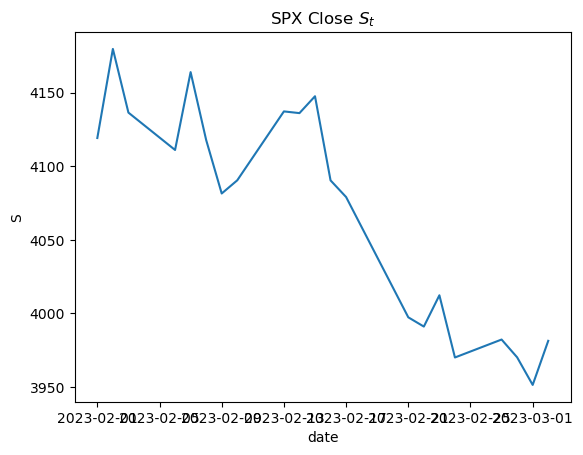

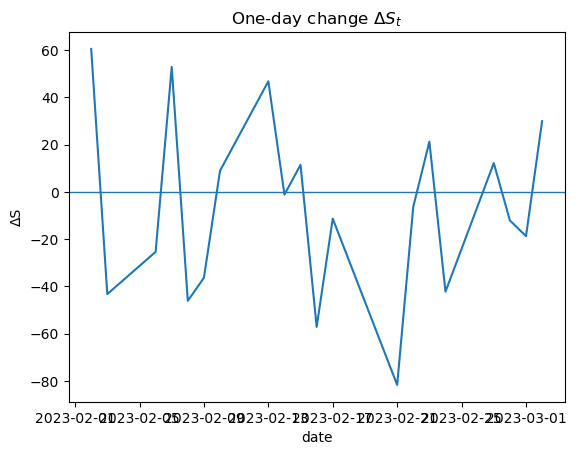

In [45]:

# step 3
def load_spx_from_stooq(start="2023-02-01", end="2023-03-02"):

    d1 = pd.Timestamp(start).strftime("%Y%m%d")
    d2 = pd.Timestamp(end).strftime("%Y%m%d")

    url = f"https://stooq.com/q/d/l/?s=^spx&d1={d1}&d2={d2}&i=d"
    spx = pd.read_csv(url)

    cols = {c.lower(): c for c in spx.columns}
    if "date" not in cols or "close" not in cols:
        raise ValueError(f"Stooq returned unexpected columns: {spx.columns.tolist()}")

    spx = spx.rename(columns={cols["date"]: "date", cols["close"]: "S"})
    spx["date"] = pd.to_datetime(spx["date"])
    spx = spx.sort_values("date").reset_index(drop=True)

    # compute one-day change
    spx["dS"] = spx["S"].diff()

    return spx

def plot_spx_and_dS(spx):
    plt.figure()
    plt.plot(spx["date"], spx["S"])
    plt.title("SPX Close $S_t$")
    plt.xlabel("date")
    plt.ylabel("S")
    plt.show()

    plt.figure()
    plt.plot(spx["date"], spx["dS"])
    plt.title("One-day change $\\Delta S_t$")
    plt.xlabel("date")
    plt.ylabel("ΔS")
    plt.axhline(0, linewidth=1)
    plt.show()

# run step 3
spx = load_spx_from_stooq(start="2023-02-01", end="2023-03-02")

# usefull for reporting 
coverage = 1 - spx["dS"].isna().mean()
print("Merge coverage:", coverage)
print("\nSummary statistics of S_t:")
print(spx["S"].describe())
print("\nSummary statistics of ΔS_t:")
print(spx["dS"].describe())


plot_spx_and_dS(spx)